In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [8]:
train_xyz = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

#print(data)
#data = data[1]

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print(obj)
    nv = obj.shape[1]
    #print(nv)
    if(nv == 8):
        train_xyz.append((obj.T.reshape(1,3,nv)))
        #print(train_xyz)
train_xyz = torch.squeeze(torch.Tensor(train_xyz))
train_xyz.shape  

#print(train_xyz)

torch.Size([0])

In [9]:
train_xy = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    nv = obj.shape[1]
    if(nv == 8):
        obj.T.reshape(1,3,nv)[0][2]=np.random.rand(nv)
        train_xy.append(obj.T.reshape(1,3,nv))
        #print(train_xyz)
train_xy = torch.squeeze(torch.Tensor(train_xy))
train_xy.shape        

torch.Size([0])

In [10]:
# new version
import torch.nn.functional as F 

from functools import reduce
def num_edges(n):
    return int(n*(n-1)/2)


class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        input_dim = vertices * 3
        edges = int(num_edges(vertices))
        edge_dim = edges * 3
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges, edges*2)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*2, edges)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(edges, vertices)
        self.reverse_learn_params.append(fc4)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    def forward_old(self, x, extract_z=False):
        #print("initial x", x)
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
        #print("output: ",output)
        n,d,e = output.size()
        
        if (extract_z):
            edge_vec = output[0,2,:]
            temp = F.sigmoid(self.reverse_learn_params[0](edge_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered
            
        for i in range(n):
            edge_vec = output[i,0,:]
            print("edge_vec: ", edge_vec)
            temp = F.sigmoid(self.reverse_learn_params[0](edge_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            print("vertex recovered: ", vertexs_recovered)
            optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 5e-1 , momentum=0.8)
            criterion = nn.MSELoss()
            optimizer.zero_grad()
            print(" orginal x: ", x[i,0,:])
            loss = criterion(vertexs_recovered, x[i,0,:])
            print("loss", loss)
            loss.backward(retain_graph=True)
            optimizer.step()
            
    def forward(self, x, extract_z=False):
        print("initial x", x)
        n,d,v = x.size()
        print(n,d,v)
        new_x = torch.tensor(x.data)
        
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](new_x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
            
        for i in range(n):
            x_vec = output[i,0,:]
            #print("x_vec: ", x_vec)
            temp = F.sigmoid(self.reverse_learn_params[0](x_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            #print("x vertex recovered: ", vertexs_recovered)
            optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 5e-1 , momentum=0.8)
            criterion = nn.MSELoss()
            optimizer.zero_grad()
            #print(" orginal x: ", x[i,:,:])
            ##x[i,2,:]=vertexs_recovered
            #print(" new x:", new_x[i])
            loss = criterion(vertexs_recovered, x[i,0,:])
            #print("loss", loss)
            loss.backward(retain_graph=True)
            optimizer.step()
            #new_x[i] = torch.stack([vertexs_recovered,x[i,0,:],x[i,1,:]])
            

        if (extract_z):
            z_vec = output[0,2,:]
            temp = F.sigmoid(self.reverse_learn_params[0](z_vec))
            temp = F.sigmoid(self.reverse_learn_params[1](temp))
            temp = F.sigmoid(self.reverse_learn_params[2](temp))
            vertexs_recovered = F.sigmoid(self.reverse_learn_params[3](temp))
            return vertexs_recovered        
        
        
            

                
        print("output: ",output)
        n,d,e = output.size()            
        output = F.normalize(output, p=2, dim=1)
        print("normalized output",output)
        #pool all dimensions for Gram Matrix
        n,d,e = output.size()
        #y = output.reshape(n, d, e).sum(1)
        #print(y.shape) # Batch X Num_Edges
        #print("y",y)
        #print("y norm",(y.norm(dim=1)[:,None]))
        #output = output/(y.norm(dim=1)[:,None])
        #print("n,d,e",n,d,e)
        #print(output.transpose(1,2)[0])
        #output = torch.mm(output.transpose(1,0),output)
        output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
        print((output))
        return torch.stack(output)

In [11]:
model = DepthEstNet(8, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.MSELoss()
print(model)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
  )
  (reverse_learn_params): ModuleList(
    (0): Linear(in_features=28, out_features=28, bias=True)
    (1): Linear(in_features=28, out_features=56, bias=True)
    (2): Linear(in_features=56, out_features=28, bias=True)
    (3): Linear(in_features=28, out_features=8, bias=True)
  )
  (layernorm): LayerNorm(torch.Size([28]), eps=1e-05, elementwise_affine=True)
  (cos): CosineSimilarity()
)


In [12]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy, train_xyz)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [13]:
lr, epochs, batch_size = 1e-1 , 100 , 100
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        #print(xy, xyz)
        local_xy = Variable(xy)
        local_xyz = Variable(xyz)
        output = model.forward(local_xy)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

NameError: name 'loader' is not defined

In [14]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

      

In [15]:
#cuboid object

data = [[[0.13454976677894592, 0.9894528388977051, -0.05366024002432823], [-0.9698463082313538, -0.1710100620985031, 0.1736481785774231], [-0.13454976677894592, -0.9894528388977051, 0.05366024002432823], [0.9698463082313538, 0.1710100620985031, -0.1736481785774231], [0.30555981397628784, 1.019606590270996, 0.9311475157737732], [-0.7988362312316895, -0.14085637032985687, 1.1584558486938477], [0.03646029531955719, -0.9592991471290588, 1.0384680032730103], [1.140856385231018, 0.20116375386714935, 0.8111595511436462]]]
obj = np.asarray(data)
obj.shape
nv = obj.shape[1]
obj = obj.T.reshape(1,3,nv)
print(obj)

[[[ 0.13454977 -0.96984631 -0.13454977  0.96984631  0.30555981
   -0.79883623  0.0364603   1.14085639]
  [ 0.98945284 -0.17101006 -0.98945284  0.17101006  1.01960659
   -0.14085637 -0.95929915  0.20116375]
  [-0.05366024  0.17364818  0.05366024 -0.17364818  0.93114752
    1.15845585  1.038468    0.81115955]]]


In [17]:
model.forward(torch.Tensor(obj))

initial x tensor([[[ 0.1345, -0.9698, -0.1345,  0.9698,  0.3056, -0.7988,  0.0365,
           1.1409],
         [ 0.9895, -0.1710, -0.9895,  0.1710,  1.0196, -0.1409, -0.9593,
           0.2012],
         [-0.0537,  0.1736,  0.0537, -0.1736,  0.9311,  1.1585,  1.0385,
           0.8112]]])
1 3 8
output:  tensor([[[1.1044, 0.0000, 0.0000, 0.6643, 1.1044, 0.0000, 0.0000, 0.2691,
          0.0000, 0.0000, 1.7687, 0.2691, 0.0000, 0.0000, 0.0000, 0.6643,
          0.9334, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9334, 0.0000,
          0.0000, 0.0981, 0.0000, 0.0000],
         [1.1605, 0.8184, 0.0000, 0.0000, 1.1605, 0.8184, 0.0000, 1.9789,
          0.0000, 0.0000, 0.3119, 1.9789, 0.0000, 0.8184, 0.0000, 0.0000,
          1.1303, 0.8184, 0.0000, 0.0000, 0.0000, 0.0000, 1.1303, 0.7883,
          0.0000, 1.9488, 0.0000, 0.7883],
         [0.0000, 0.1200, 0.2273, 0.0000, 0.0000, 0.1200, 0.2273, 0.0000,
          0.3473, 0.0000, 0.0000, 0.0000, 0.3473, 0.1200, 0.0000, 0.0000,
          0.0000

/home/mishra/miniconda3/envs/3dvision/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[[1.0000, 0.7167, 0.0000, 0.6894, 1.0000, 0.7167, 0.0000, 0.8107,
          0.0000, 0.0000, 0.8047, 0.8107, 0.0000, 0.7167, 0.0000, 0.6894,
          0.9975, 0.7167, 0.0000, 0.0000, 0.0000, 0.0000, 0.9975, 0.7244,
          0.0000, 0.7581, 0.0000, 0.7244],
         [0.7167, 1.0000, 0.1451, 0.0000, 0.7167, 1.0000, 0.1451, 0.9804,
          0.1451, 0.0000, 0.1718, 0.9804, 0.1451, 1.0000, 0.0000, 0.0000,
          0.7629, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7629, 0.9894,
          0.0000, 0.9882, 0.0000, 0.9894],
         [0.0000, 0.1451, 1.0000, 0.0000, 0.0000, 0.1451, 1.0000, 0.0000,
          1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1451, 0.0000, 0.0000,
          0.0000, 0.1451, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.6894, 0.0000, 0.0000, 1.0000, 0.6894, 0.0000, 0.0000, 0.1347,
          0.0000, 0.0000, 0.9848, 0.1347, 0.0000, 0.0000, 0.0000, 1.0000,
          0.6367, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [637]:
model.forward(torch.Tensor([[[ 0.4154,  0.4154, -0.1423,  1.0000],
[ 0.9096,  0.9096, -0.9898, -0.0000],
[ 0.0000,  1.0000,  1.0000,  1.0000]]]), extract_z=True)


1 3 4


tensor([ 1.3111e-06,  1.1818e-06,  1.1096e-06,  9.9265e-01])

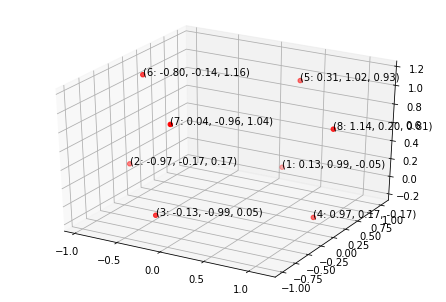

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.13454977, -0.96984631, -0.13454977,  0.96984631,  0.30555981,
   -0.79883623,  0.0364603,   1.14085639]
y =  [ 0.98945284, -0.17101006, -0.98945284,  0.17101006,  1.01960659,
   -0.14085637 , -0.95929915 , 0.20116375]
z =[ -0.0537,  0.1736,  0.0537, -0.1736,  0.9311,  1.1585,  1.0385,
           0.8112 ]
# x=[(i-min(x))/(max(x)-min(x)) for i in x]
# y=[(i-min(y))/(max(y)-min(y)) for i in y]
# z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]

#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')

i=1
for xs,ys,zs in zip(x,y,z):
    label = '({:d}: {:.2f}, {:.2f}, {:.2f})'.format(i,xs,ys,zs)
    ax.text(xs, ys, zs, label, zdir=None)
    i=i+1
    
plt.show()

In [ ]:
[[ 0.4154,  0.4154, -0.1423,  1.0000],
[ 0.9096,  0.9096, -0.9898, -0.0000],
[ 0.0000,  1.0000,  1.0000,  1.0000]]

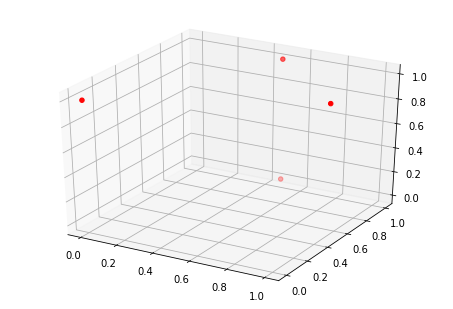

In [634]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.4154,  0.4154, -0.1423,  1.0000]
y = [ 0.9096,  0.9096, -0.9898, -0.0000]
z = [ 0.0000,  1.0000,  1.0000,  1.0000]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

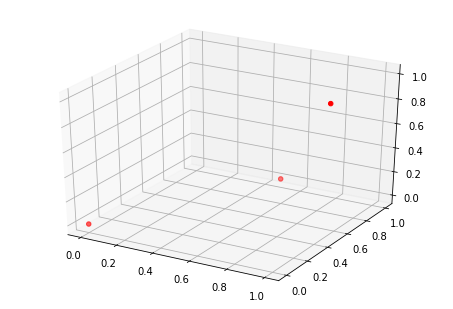

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.4154,  0.4154, -0.1423,  1.0000]
y = [ 0.9096,  0.9096, -0.9898, -0.0000]
z = [ 0.0000,  0.0015,  0.0000,  0.9997]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

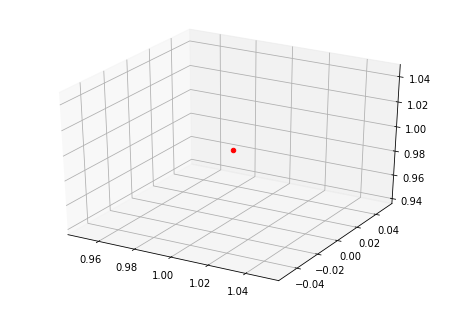

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [   1.0000]
y = [  -0.0000]
z = [ 9.9265e-01]


verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()